# PM2.5 Prediction Model

## Quick Summary

1. Notebooks named model_1 and model_2 use date_time based time series features (year, month, day, hour, season) as regular features for forecasting: <br>
    * Model_1 uses all the date_time features (year, month, day, hour, season) and meteorological features from the original dataset, the results are not quite satisfying, best performance R2 achieved is around 0.5.
    * Model_ 2 removes the ‘iws’ (cumulated wind speed) column and only keeps the ‘ws’ (hourly wind speed) column, because the numbers in the ‘iws’ column from the original dataset contain periodically reset to zero when wind direction alters, causing undesired artifacts. Therefore, the hourly wind speed ‘ws’ was extracted from the ‘iws’ column during the data wrangling step and it makes better sense to only use the hourly wind speed data ('ws') and drop the ‘iws’ column for modeling. However, all the model performances become slightly worse after dropping the ‘iws’ feature.  
2. Notebooks named moel_3 and model_4 add additional lag features (values at previous steps): <br>
    * Model_3 introduces the lag feature of 1 hour (value from the previous one step), In this case, it’s very useful to include the values at previous time steps for predicting the value for the next step, the R2 scores after adding lag features are boosted to around 0.95. 
    * Model_4 introduces the lag feature of 24 hours (value from the 24 steps back in time, corresponding to the same hour in previous day). The lag feature of 24 hrs is not as helpful as the lag feature of 1hr, but it does help to improve model performance. The lag feature of 24 hrs boosts the R2 metrics to 0.56. 
3. Adding PCA as a preprocessing step in this case:  
    * PCA is helpful in the case of KNeighborsRegressor (kNN) model and MLPRegressor(neutral nets) model
    * PCA shows little difference in linear models (LinearRegression, Lasso and Ridge);
    * PCA shows little difference, if not actually makes it worse, in tree-based models (RandomForestRegressor and GradientBoostingRegressor).
4.	Model comparison:
    * Ranking of feature importance is only possible without using PCA for selective algorithms (LinearRegression, Lasso, Ridge, RandomForestRegressor, GradientBoostingRegressor). For KNeighborsRegressor and MLPRegressor, ranking of feature importance seems impossible (fitting results harder to interpret) 
    * Model performance: Neural network-based algorithms (MLPRegressor) and Tree-based algorithms (RandomForestRegressor and GradientBoostingRegressor) in general give the best performance (R2_score and mean_squared_error), followed by KNeighborsRegressor, followed by linear models (LinearRegression, Lasso and Ridge). But GradientBoostingRegressor takes longer to train because it only works in sequential order; MLPRegressor is harder to design hidden layer structures. 

In [1]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler #, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))
print(pm_clean.info())

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 168895 entries, 0 to 168894
Data columns (total 17 columns):
year             168895 non-null int64
month            168895 non-null int64
day              168895 non-null int64
hour             168895 non-null int64
season           168895 non-null int64
dewp             168895 non-null float64
humi             168895 non-null float64
pres             168895 non-null float64
temp             168895 non-null float64
cbwd             168895 non-null object
iws              168895 non-null float64
precipitation    168895 non-null float64
iprec            168895 non-null float64
city             168895 non-null object
pm_average       168895 non-null

In [3]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# drop target column 'pm_average' and columns containing irrelevant or duplicated information 'city','date_time'
X = bj.drop(['pm_average','city','date_time'], axis=1)
X = pd.get_dummies(X, drop_first=True)
print(X.info())
print(X.describe())
y = bj['pm_average']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49854 entries, 0 to 49853
Data columns (total 14 columns):
year             49854 non-null int64
month            49854 non-null int64
day              49854 non-null int64
hour             49854 non-null int64
season           49854 non-null int64
dewp             49854 non-null float64
humi             49854 non-null float64
pres             49854 non-null float64
temp             49854 non-null float64
cbwd             49854 non-null object
iws              49854 non-null float64
precipitation    49854 non-null float64
iprec            49854 non-null float64
ws               49854 non-null float64
dtypes: float64(8), int64(5), object(1)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49854 entries, 0 to 49853
Data columns (total 16 columns):
year             49854 non-null int64
month            49854 non-null int64
day              49854 non-null int64
hour             49854 non-null int64
season        

In [4]:
# train test split by year, using data of year 2010-2014 as training set and data of year 2015 as test set

X_train = X[X['year'] != 2015]
y_train = y[X['year'] != 2015]
print(len(X_train), len(y_train))

X_test = X[X['year'] == 2015]
y_test = y[X['year'] == 2015]
print(len(X_test),len(y_test))

41892 41892
7962 7962


In [5]:
# initialize a score table

index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor','KNeighborsRegressor','MLPRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])
print(score_table)

                          r2_train r2_test mse_train mse_test
LinearRegression               NaN     NaN       NaN      NaN
Lasso                          NaN     NaN       NaN      NaN
Ridge                          NaN     NaN       NaN      NaN
RandomForestRegressor          NaN     NaN       NaN      NaN
GradientBoostingRegressor      NaN     NaN       NaN      NaN
KNeighborsRegressor            NaN     NaN       NaN      NaN
MLPRegressor                   NaN     NaN       NaN      NaN


### LinearRegression model

In [6]:
# explore with LinearRegression model using default parameters

scaler = StandardScaler()
linreg = LinearRegression()
linreg_1 = Pipeline([('scaler', scaler),('linreg',linreg)])
linreg_1.fit(X_train, y_train)
y_pred_train = linreg_1.predict(X_train)
y_pred_test = linreg_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':linreg_1.named_steps.linreg.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.3159430732657681 0.2740712672501616
5577.5216194685145 6009.062627828797
[ -1.92839094  -4.89015519   6.53040347  10.28683395   7.63218677
 -40.71187398  55.17328577 -17.89176282   4.69419193  -5.10446897
  -1.70730774  -7.16503178 -10.48693804  -7.29517624 -12.31847309
   4.06616284] 97.14399129507635


In [7]:
# adding PCA as a preprocessing step to decorrelate features

pca = PCA()
scaler = StandardScaler()
linreg = LinearRegression()
linreg_2 = Pipeline([('pca', pca),('scaler', scaler),('linreg',linreg)])
linreg_2.fit(X_train, y_train)
y_pred_train = linreg_2.predict(X_train)
y_pred_test = linreg_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(linreg_2.named_steps.linreg.coef_, linreg_2.named_steps.linreg.intercept_)

# add scores to the score table
score_table.loc['LinearRegression',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.3159430732657682 0.27407126725016184
5577.5216194685145 6009.0626278287955
[-26.25940269  26.68911778  20.06673146   6.44349761 -11.70040592
  11.17533972 -11.46324814  -2.3415914   -9.98188625   3.78210054
   3.82102716  -5.06902525  -1.52706672  11.86439981  -2.19618124
   5.40185109] 97.14399129507623


Adding PCA to decorrelate features doesn't affect the model performance at all. In fact, the performance also remains the same without the StandardScaler.

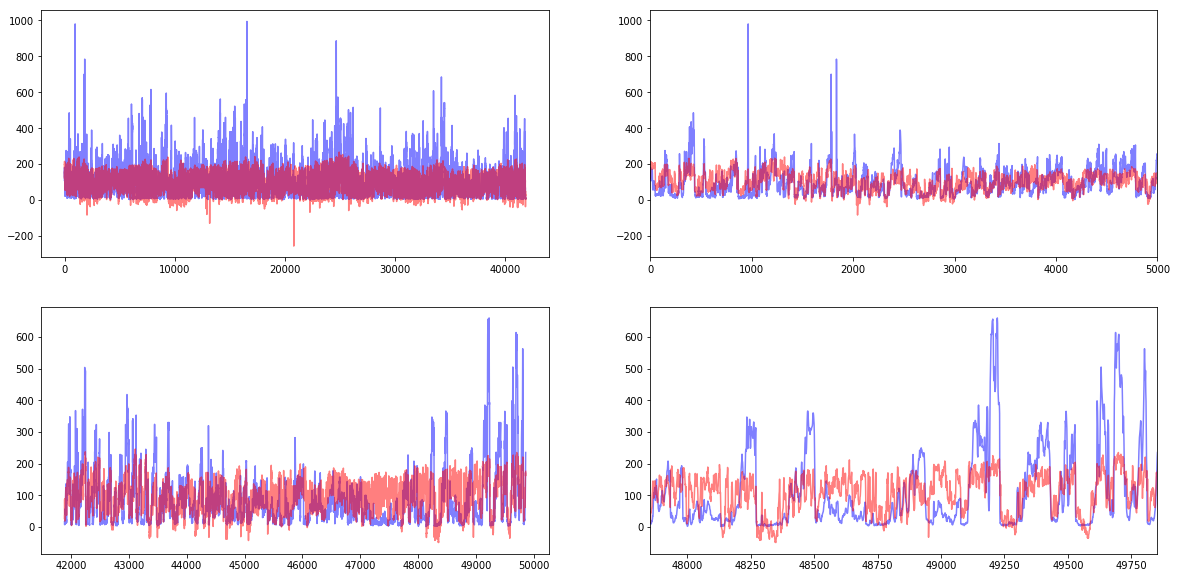

In [8]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

The linear regression model seems to catch some of the periodic trends in both the training and the testing sets, but two major problems are noticed: 
1) the model fails to catch and predict the extremely high PM2.5 values
2) negative PM2.5 values are predicted by the model, whereas in reality, the values should always be non-negative.

### Lasso model

In [9]:
# explore with LASSO model using default parameters

scaler = StandardScaler()
lasso= Lasso()
lasso_1 = Pipeline([('scaler', scaler),('lasso',lasso)])
lasso_1.fit(X_train, y_train)
y_pred_train = lasso_1.predict(X_train)
y_pred_test = lasso_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso_1.named_steps.lasso.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.30898560221701765 0.2506040241504309
5634.250005184151 6203.318795310407
[ -0.69264322  -4.31241927   5.41312679   8.99927016   5.24593719
  -0.50917243  33.70535701 -11.18063122 -20.37886725  -4.59903603
  -1.0126066   -6.05234499  -9.41050572  -6.16117083 -11.07856831
   2.98788378] 97.14399129507629


In [10]:
# adding PCA as a preprocessing step to decorrelate features

lasso_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso())])
lasso_2.fit(X_train, y_train)
y_pred_train = lasso_2.predict(X_train)
y_pred_test = lasso_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_2.named_steps.lasso.coef_, lasso_2.named_steps.lasso.intercept_)

0.31398074813742727 0.2689787438818789
5593.5216194685145 6051.217305654779
[-25.25940269  25.68911778  19.06673146   5.44349761 -10.70040592
  10.17533972 -10.46324814  -1.3415914   -8.98188625   2.78210054
   2.82102716  -4.06902525  -0.52706672  10.86439981  -1.19618124
   4.40185109] 97.14399129507623


In [11]:
# grid search of parameter alpha to improve lasso model

parameters = {'lasso__alpha': np.arange(0.3,1,0.05)}
lasso_cv = GridSearchCV(lasso_2, parameters, scoring='r2',cv=3)
lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'lasso__alpha': 0.7999999999999998}
0.28205406683956136


In [12]:
# update model with best parameters

lasso_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso(alpha=0.8))])
lasso_3.fit(X_train, y_train)
y_pred_train = lasso_3.predict(X_train)
y_pred_test = lasso_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_3.named_steps.lasso.coef_, lasso_3.named_steps.lasso.intercept_)

# add scores to the score table
score_table.loc['Lasso',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.31468718518363004 0.27031158245922215
5587.761619468513 6040.18438999417
[-25.45940269  25.88911778  19.26673146   5.64349761 -10.90040592
  10.37533972 -10.66324814  -1.5415914   -9.18188625   2.98210054
   3.02102716  -4.26902525  -0.72706672  11.06439981  -1.39618124
   4.60185109] 97.14399129507623


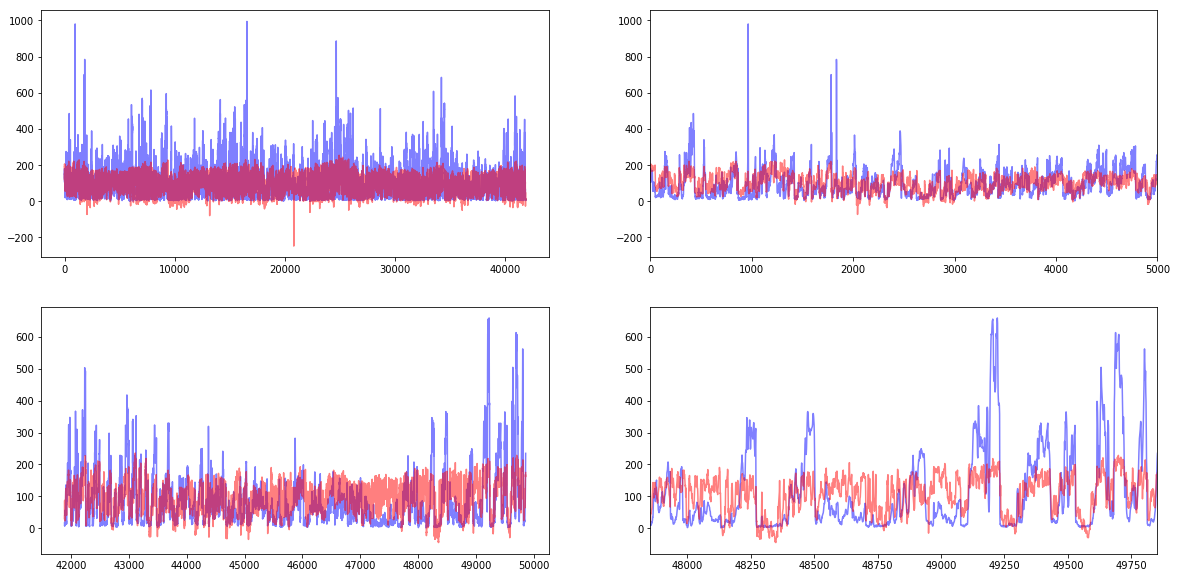

In [13]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### Ridge model

In [14]:
# explore with Ridge model using default parameters

ridge_1 = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])
ridge_1.fit(X_train, y_train)
y_pred_train = ridge_1.predict(X_train)
y_pred_test = ridge_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':ridge_1.named_steps.ridge.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.315943054681991 0.27406308402754853
5577.521770993066 6009.1303665681
[ -1.92769458  -4.8898935    6.53014233  10.28642552   7.63022182
 -40.62795358  55.12693049 -17.89053543   4.62977319  -5.10501492
  -1.70726498  -7.16406086 -10.4851147   -7.29494001 -12.31775964
   4.06490015] 97.14399129507635


In [15]:
# adding PCA as a preprocessing step to decorrelate features

ridge_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge())])
ridge_2.fit(X_train, y_train)
y_pred_train = ridge_2.predict(X_train)
y_pred_test = ridge_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_2.named_steps.ridge.coef_, ridge_2.named_steps.ridge.intercept_)

0.3159430730857461 0.2740716844272503
5577.521620936341 6009.059174537669
[-26.25877587  26.68848071  20.06625246   6.4433438  -11.70012663
  11.17507296 -11.46297451  -2.34153551  -9.98164798   3.78201026
   3.82093595  -5.06890425  -1.52703027  11.8641166   -2.19612882
   5.40172214] 97.14399129507623


In [16]:
# grid search of parameter alpha to improve Ridge model

parameters = {'ridge__alpha': np.arange(1,2500, 100)}
ridge_cv = GridSearchCV(ridge_2, parameters, scoring='r2',cv=3)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'ridge__alpha': 1801}
0.2812750488424858


In [17]:
# update model with best parameters

ridge_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge(alpha=1801))])
ridge_3.fit(X_train, y_train)
y_pred_train = ridge_3.predict(X_train)
y_pred_test = ridge_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_3.named_steps.ridge.coef_, ridge_3.named_steps.ridge.intercept_)

# add scores to the score table
score_table.loc['Ridge',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.31540627323207415 0.2742624312490878
5581.898468347969 6007.480218440782
[-25.17700541  25.5890079   19.23959248   6.17790039 -11.21812201
  10.71469873 -10.99073974  -2.24507237  -9.57043872   3.62620456
   3.66352665  -4.86008298  -1.46412192  11.37535616  -2.10565593
   5.17918993] 97.14399129507623


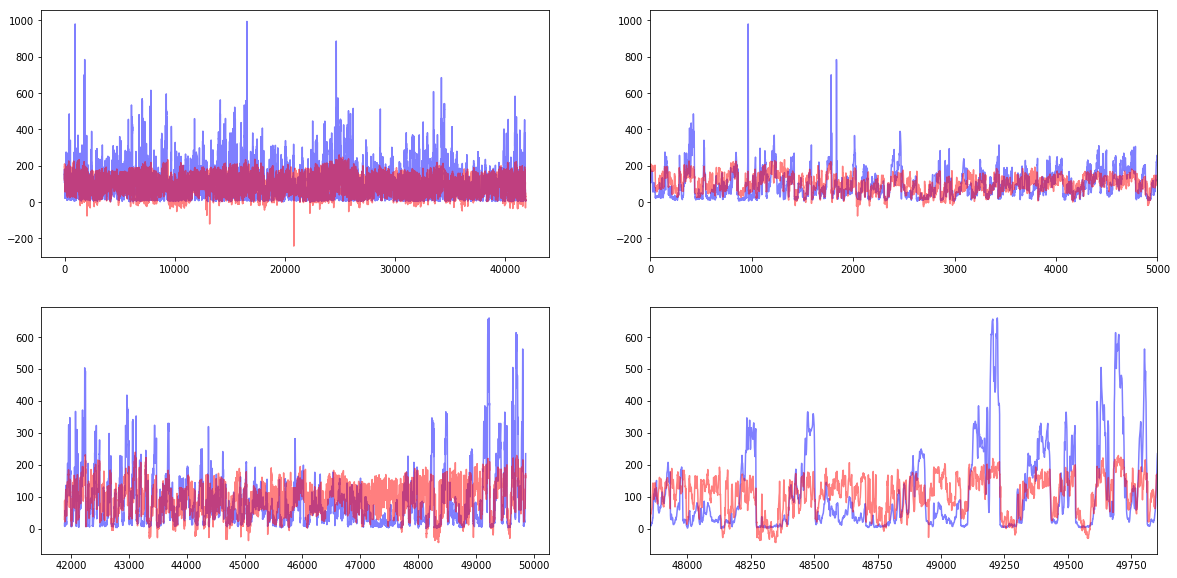

In [18]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### RandomForestRegressor model

In [19]:
# explore with RandomForestRegressor model using default parameters

rfr_1 = Pipeline([('scaler', StandardScaler()),('rfr',RandomForestRegressor())])
rfr_1.fit(X_train, y_train)
y_pred_train = rfr_1.predict(X_train)
y_pred_test = rfr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_1.named_steps.rfr.n_features_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr_1.named_steps.rfr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.9712390340961694 0.4313019313241191
234.50520396197365 4707.545185673616
16
          feature  importance
6            humi    0.215525
5            dewp    0.151958
2             day    0.136412
7            pres    0.090356
1           month    0.088579
9             iws    0.058094
0            year    0.055104
4          season    0.051712
3            hour    0.048783
8            temp    0.031416
14        cbwd_NW    0.030317
12             ws    0.021200
13        cbwd_NE    0.010339
15        cbwd_SE    0.004744
11          iprec    0.003516
10  precipitation    0.001946


In [20]:
# adding PCA as a preprocessing step to decorrelate features

rfr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr',RandomForestRegressor(n_jobs=2))])
rfr_2.fit(X_train, y_train)
y_pred_train = rfr_2.predict(X_train)
y_pred_test = rfr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_2.named_steps.rfr.n_features_)

0.944246581782283 0.3833882812110514
454.59066828425205 5104.1628028970945
16
          feature  importance
0            year    0.178771
2             day    0.098770
3            hour    0.088461
6            humi    0.084648
7            pres    0.084054
11          iprec    0.073229
13        cbwd_NE    0.066322
1           month    0.050564
10  precipitation    0.050162
4          season    0.048590
5            dewp    0.041809
9             iws    0.037423
12             ws    0.033087
14        cbwd_NW    0.024723
8            temp    0.021007
15        cbwd_SE    0.018381


In comparison to linear models, RandomForestRegressor performs better at catching extreme values and eliminating negative prediction values. 
The score reveals that the RandomForestRegressor with default parameters suffer significantly from overfitting, parameter optimization is very important. 

In [21]:
# grid search of parameter n_estimators and max_features to improve RandomForestRegressor model

parameters = {'rfr__n_estimators': np.arange(20,180,10), 'rfr__max_features':['auto','sqrt','log2']}
rfr_cv = GridSearchCV(rfr_2, parameters, scoring='r2',cv=3)
rfr_cv.fit(X_train, y_train)
print(rfr_cv.best_params_)
print(rfr_cv.best_score_)

{'rfr__max_features': 'log2', 'rfr__n_estimators': 160}
0.37509286442315254


In [22]:
# update model with best parameters

rfr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=150, max_features='sqrt', n_jobs=2))])
rfr_3.fit(X_train, y_train)
y_pred_train = rfr_3.predict(X_train)
y_pred_test = rfr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_3.named_steps.rfr.n_features_)

# add scores to the score table
score_table.loc['RandomForestRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.960336577374831 0.46287672096555954
323.3993963779362 4446.176707121715
16
          feature  importance
0            year    0.129231
2             day    0.086737
6            humi    0.083172
7            pres    0.081273
1           month    0.079760
11          iprec    0.070246
3            hour    0.065880
13        cbwd_NE    0.056570
10  precipitation    0.049394
4          season    0.048350
9             iws    0.046873
5            dewp    0.044444
12             ws    0.044222
8            temp    0.040886
14        cbwd_NW    0.036621
15        cbwd_SE    0.036343


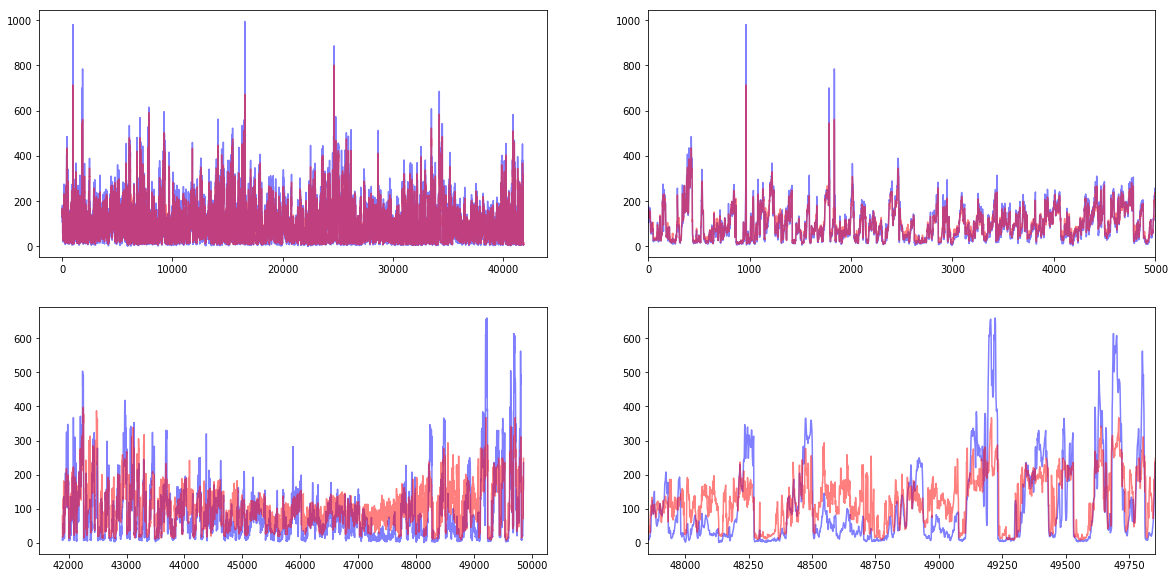

In [23]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### GradientBoostingRegressor model

In [24]:
# explore with GradientBoostingRegressor model using default parameters

gbr_1 = Pipeline([('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_1.fit(X_train, y_train)
y_pred_train = gbr_1.predict(X_train)
y_pred_test = gbr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_1.named_steps.gbr.train_score_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr_1.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.5477755427452573 0.5097432554047199
3687.254069968211 4058.2268604096125
[7696.45102366 7318.82205595 7008.59676316 6742.81041834 6518.99552361
 6323.72860584 6167.30996238 6016.80571727 5900.32981523 5789.81930055
 5691.19815168 5610.40235115 5535.64936398 5474.54996933 5411.01073776
 5344.40248494 5290.2723677  5241.49227313 5177.22220844 5123.72405926
 5087.38486343 5040.16786078 4987.09218112 4925.67796327 4895.19039117
 4861.34547984 4836.74866844 4789.63097818 4762.97376866 4735.17375865
 4711.49236328 4662.01578598 4640.21298839 4609.0166989  4588.34299116
 4534.53585948 4515.6633457  4493.60909904 4477.15809552 4457.82426313
 4441.28213048 4418.65177437 4378.25823348 4354.85596082 4337.99374958
 4305.99571558 4292.9749376  4278.97501916 4256.5015361  4242.38334855
 4223.13815781 4216.65193514 4204.6780853  4180.14701832 4172.41640069
 4152.30635713 4134.7239049  4124.39894268 4109.39840578 4096.82532324
 4086.20299299 4065.7181987  4051.32262525 4040.38685632 4029.23615701
 4

In [25]:
# adding PCA as a preprocessing step to decorrelate features

gbr_2 = Pipeline([('pca',PCA()),('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_2.fit(X_train, y_train)
y_pred_train = gbr_2.predict(X_train)
y_pred_test = gbr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_2.named_steps.gbr.train_score_)

0.48530932458296316 0.44483653564294223
4196.578175419444 4595.509001781832
[7722.48289841 7370.07547727 7081.23779814 6825.48592059 6611.45431036
 6424.1231922  6265.51269422 6122.52524833 5981.6369436  5876.498978
 5768.00361046 5678.15851955 5597.20154179 5532.71024454 5474.0288542
 5413.99391202 5362.33875392 5314.02874087 5272.37943302 5225.31969649
 5182.16050561 5151.44705697 5111.07915601 5086.35306366 5054.33569375
 5017.28098055 4994.10356255 4971.31290752 4942.9777373  4913.10081242
 4887.29175541 4861.55656875 4838.82530535 4825.18503761 4812.7037706
 4795.45093983 4774.98434182 4754.31837561 4735.34651141 4721.97016336
 4701.1412935  4685.57725236 4676.64239125 4659.70864764 4647.45514357
 4637.90619113 4626.18868294 4612.57532543 4603.70105167 4583.60207018
 4576.39129322 4565.18114145 4556.83491774 4548.22390914 4538.57652954
 4524.2281148  4503.92627659 4493.35512477 4485.99173539 4476.09188363
 4468.583618   4457.84139209 4445.46965062 4440.3043384  4432.68436292
 4421

In [26]:
# grid search of parameter n_estimators, max_features, max_depth, learning_rate to improve GradientBoostingRegressor model

parameters = {'gbr__n_estimators': np.arange(50,600,50), 'gbr__learning_rate': [0.01, 0.05, 0.1, 0.15],'gbr__max_features':['auto','sqrt','log2'],'gbr__max_depth': np.arange(2,7,2)}
gbr_cv = GridSearchCV(gbr_2, parameters, scoring='r2',cv=3)
gbr_cv.fit(X_train, y_train)
print(gbr_cv.best_params_)
print(gbr_cv.best_score_)

{'gbr__learning_rate': 0.05, 'gbr__max_depth': 6, 'gbr__max_features': 'log2', 'gbr__n_estimators': 100}
0.3918521391401948


In [42]:
# update model with best parameters

gbr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),
                  ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_features='log2', max_depth=6))])
gbr_3.fit(X_train, y_train)
y_pred_train = gbr_3.predict(X_train)
y_pred_test = gbr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_3.named_steps.gbr.train_score_)

# add scores to the score table
score_table.loc['GradientBoostingRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.5981607030566607 0.46997407429661087
3276.4339905942866 4387.426531334398
[7896.21889174 7660.76035284 7416.10376752 7198.1406343  7011.24572028
 6826.17066673 6646.07676963 6501.32774876 6324.28118172 6196.97277877
 6071.04227602 5936.48683863 5814.97424644 5716.33272465 5616.86352436
 5507.42526901 5395.19081179 5315.66660425 5245.59943627 5178.2603042
 5105.50918627 5059.5882986  4993.70724845 4930.97905664 4879.61654827
 4823.14468068 4761.49728347 4710.67030373 4657.0439577  4615.22241127
 4571.00553393 4541.80987667 4504.80476291 4466.762576   4435.84793686
 4395.77192122 4350.42950732 4313.452813   4275.64517729 4246.92549641
 4220.2661915  4190.97341635 4159.21482716 4136.30917845 4113.69028398
 4086.71968274 4060.89769417 4033.89931297 4014.90021028 3989.92314941
 3967.76787185 3942.46168002 3921.20167212 3906.10815299 3888.24693553
 3867.6146664  3845.97584596 3822.69254641 3800.26966454 3787.67076557
 3768.31604837 3749.5396738  3736.58779812 3726.72472573 3710.78400158
 3

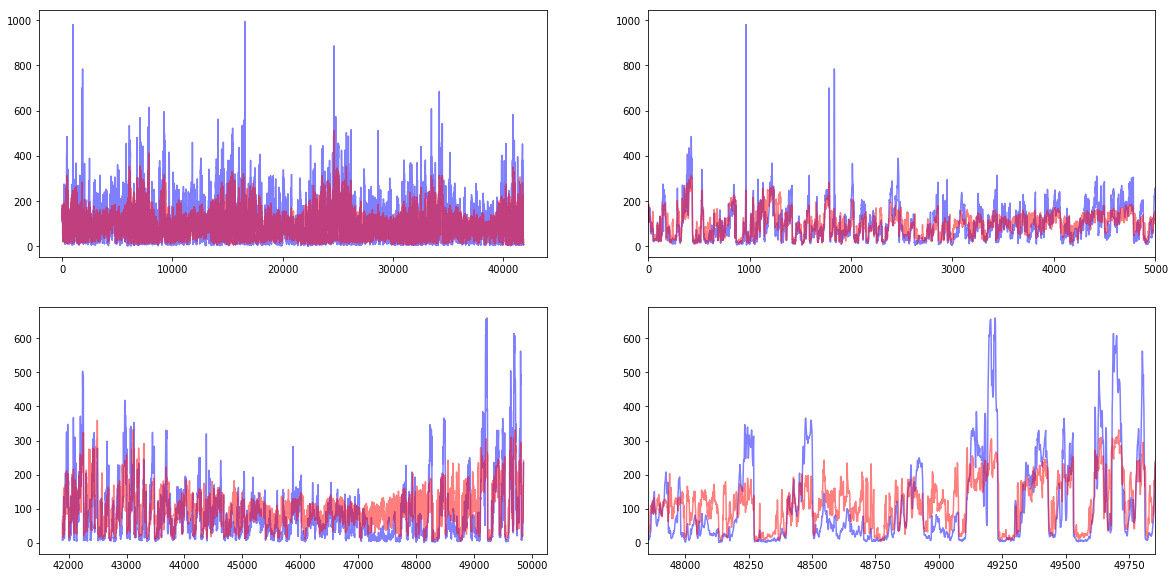

In [28]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### KNeighborsRegressor model

In [29]:
# explore with KNeighborsRegressor model using default parameters

knr_1 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_1.fit(X_train, y_train)
y_pred_train = knr_1.predict(X_train)
y_pred_test = knr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.8200632790768655 0.24689958250185562
1467.130748717602 6233.983268092886


In [30]:
# adding PCA as a preprocessing step to decorrelate features

knr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_2.fit(X_train, y_train)
y_pred_train = knr_2.predict(X_train)
y_pred_test = knr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.7977163289742903 0.26451147872043934
1649.3386797465969 6088.196247139189


In [31]:
# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model

parameters = {'knr__n_neighbors': np.arange(1,100,10),'knr__weights':['distance','uniform']}
knr_cv = GridSearchCV(knr_2, parameters, scoring='r2',cv=3)
knr_cv.fit(X_train, y_train)
print(knr_cv.best_params_)
print(knr_cv.best_score_)

{'knr__n_neighbors': 71, 'knr__weights': 'distance'}
0.33461315926241975


In [32]:
# update model with best parameters

knr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=71, weights='distance', n_jobs=2))])
knr_3.fit(X_train, y_train)
y_pred_train = knr_3.predict(X_train)
y_pred_test = knr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

# add scores to the score table
score_table.loc['KNeighborsRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

1.0 0.36596662172374883
1.2163381360881004e-21 5248.375090160264


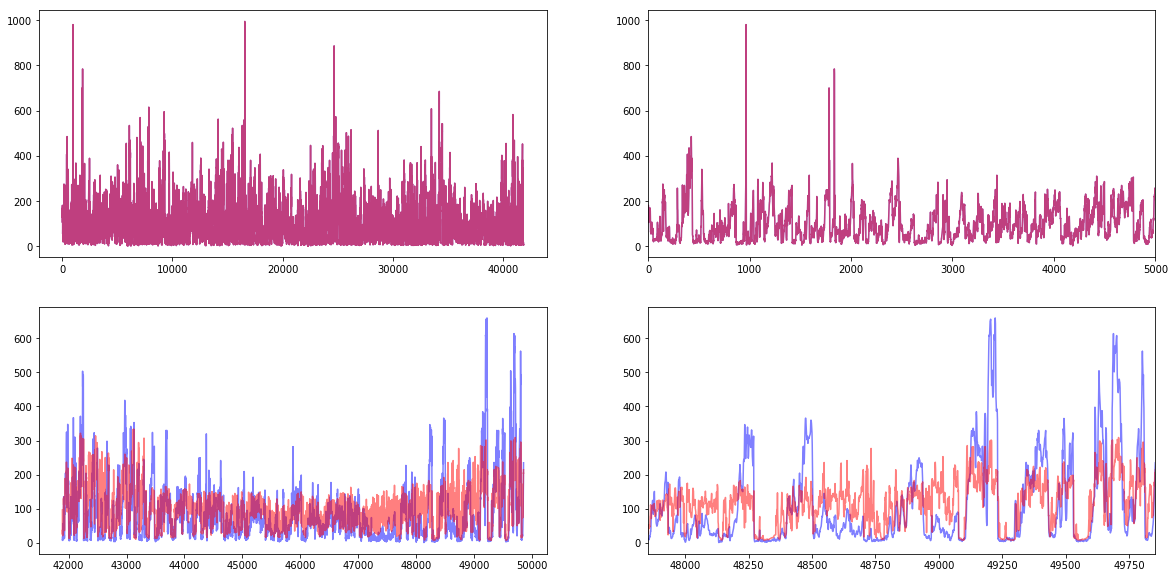

In [33]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### MLPRegressor model

In [34]:
# explore with MLPRegressor model using default parameters

mlpr_1 = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_1.fit(X_train, y_train)
y_pred_train = mlpr_1.predict(X_train)
y_pred_test = mlpr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_1.named_steps.mlpr.n_layers_, mlpr_1.named_steps.mlpr.loss_)

0.6033554469381106 0.46578724706621744
3234.078164384452 4422.084075393896
3 1622.1088496793134


In [35]:
# adding PCA as a preprocessing step to decorrelate features

mlpr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_2.fit(X_train, y_train)
y_pred_train = mlpr_2.predict(X_train)
y_pred_test = mlpr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_2.named_steps.mlpr.n_layers_, mlpr_2.named_steps.mlpr.loss_)

0.5992248301131187 0.47178410215027156
3267.75753190891 4372.443558158008
3 1637.8114335519751


In [36]:
# grid search of parameters hidden_layer_sizes, activation to improve MLPRegressor model

parameters = {'mlpr__activation': ['identity','logistic','tanh','relu'],'mlpr__hidden_layer_sizes':[(100,),(100,20),(50,100),(50,100,20)]}
mlpr_cv = GridSearchCV(mlpr_2, parameters, scoring='r2',cv=3)
mlpr_cv.fit(X_train, y_train)
print(mlpr_cv.best_params_)
print(mlpr_cv.best_score_)

{'mlpr__activation': 'relu', 'mlpr__hidden_layer_sizes': (100,)}
0.40414893449612366


In [39]:
# update model with best parameters

mlpr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))])
mlpr_3.fit(X_train, y_train)
y_pred_train = mlpr_3.predict(X_train)
y_pred_test = mlpr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_3.named_steps.mlpr.n_layers_, mlpr_3.named_steps.mlpr.loss_)

# add scores to the score table
score_table.loc['MLPRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.5905427960183907 0.4702786283221533
3338.547302426243 4384.90550670694
3 1673.4132004262046


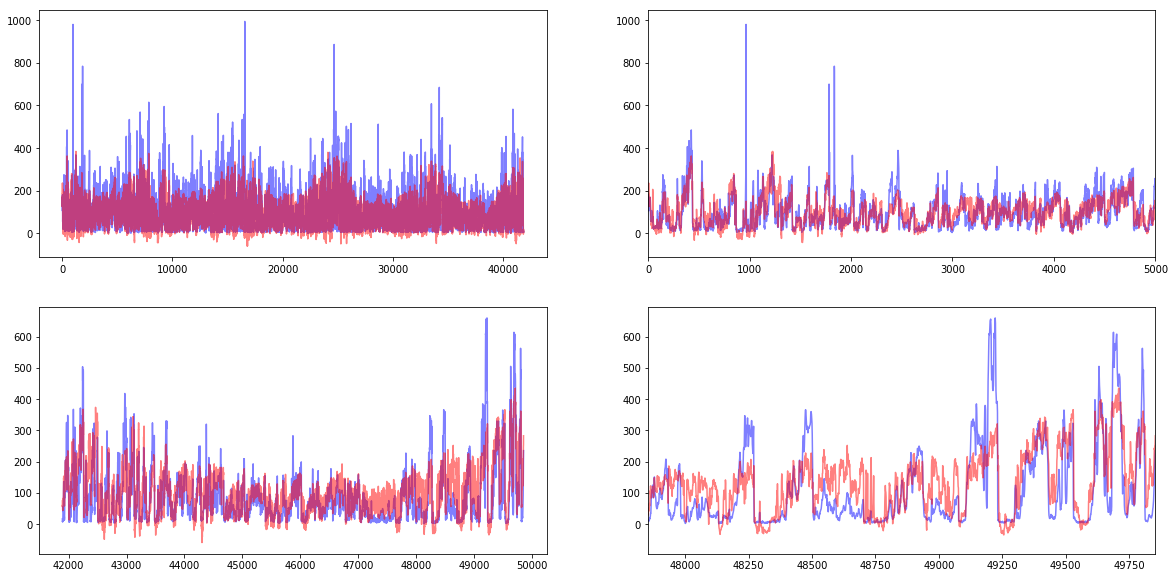

In [40]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

In [44]:
# output the summary table of scoring for different algorithms
print(score_table)

                           r2_train   r2_test    mse_train mse_test
LinearRegression           0.315943  0.274071      5577.52  6009.06
Lasso                      0.314687  0.270312      5587.76  6040.18
Ridge                      0.315406  0.274262       5581.9  6007.48
RandomForestRegressor      0.960337  0.462877      323.399  4446.18
GradientBoostingRegressor  0.598161  0.469974      3276.43  4387.43
KNeighborsRegressor               1  0.365967  1.21634e-21  5248.38
MLPRegressor               0.590543  0.470279      3338.55  4384.91
